# Relatório Final — Simulação do Problema de Riemann 1D

Este notebook consolida o projeto **Riemann-ML**, visando reproduzir e analisar o problema de Sod para o sistema de Euler 1D. Todas as células foram adaptadas para execução direta no Google Colab.

## 1. Preparação do ambiente

As células abaixo detectam se estamos no Colab, instalam as dependências e clonam o repositório para reproduzir os experimentos.

In [9]:
import sys
from pathlib import Path

IN_COLAB = 'google.colab' in sys.modules
print('Executando no Colab?' , IN_COLAB)

if IN_COLAB:
    PROJECT_ROOT = Path('/content/Riemann-ML')
    if not PROJECT_ROOT.exists():
        PROJECT_ROOT = Path.cwd()
else:
    PROJECT_ROOT = Path.cwd()
    if not (PROJECT_ROOT / 'src').exists():
        PROJECT_ROOT = PROJECT_ROOT.parent

SRC_PATH = PROJECT_ROOT / 'src'
if not SRC_PATH.exists():
    raise FileNotFoundError(f'Arquivos de código não encontrados em {SRC_PATH}')

if str(SRC_PATH) not in sys.path:
    sys.path.insert(0, str(SRC_PATH))

print(f'PROJECT_ROOT: {PROJECT_ROOT}')


Executando no Colab? False
PROJECT_ROOT: c:\Users\Joao\fluid-dynamics\Fluid-Dynamics-ML


## 2. Contexto físico

- **Equações de Euler 1D:** conservação de massa, momento e energia em um gás ideal.
- **Problemas de Riemann:** condições iniciais com descontinuidade geram ondas de choque, rarefações e contatos.
- **Sod shock tube:** caso clássico [Sod, 1978] utilizado para testes numéricos.

In [10]:
import numpy as np
from riemann_ml.core.euler1d import StatePrim
from riemann_ml.fvm.solver import simulate
from riemann_ml.exact.sod_exact import sod_exact_profile

GAMMA = 1.4
NUM_CELLS = 200
FINAL_TIME = 0.2
CFL = 0.5
INTERFACE = 0.5

left_state = StatePrim(density=1.0, velocity=0.0, pressure=1.0)
right_state = StatePrim(density=0.125, velocity=0.0, pressure=0.1)

print('Executando FVM Sod...')
times, x_grid, cons_final, _ = simulate(
    num_cells=NUM_CELLS,
    final_time=FINAL_TIME,
    cfl=CFL,
    left_state=left_state,
    right_state=right_state,
    gamma=GAMMA,
    interface_position=INTERFACE,
    store_history=False,
)
print(f'Tempo final: {times[-1]:.4f} s')


Executando FVM Sod...
Tempo final: 0.2000 s


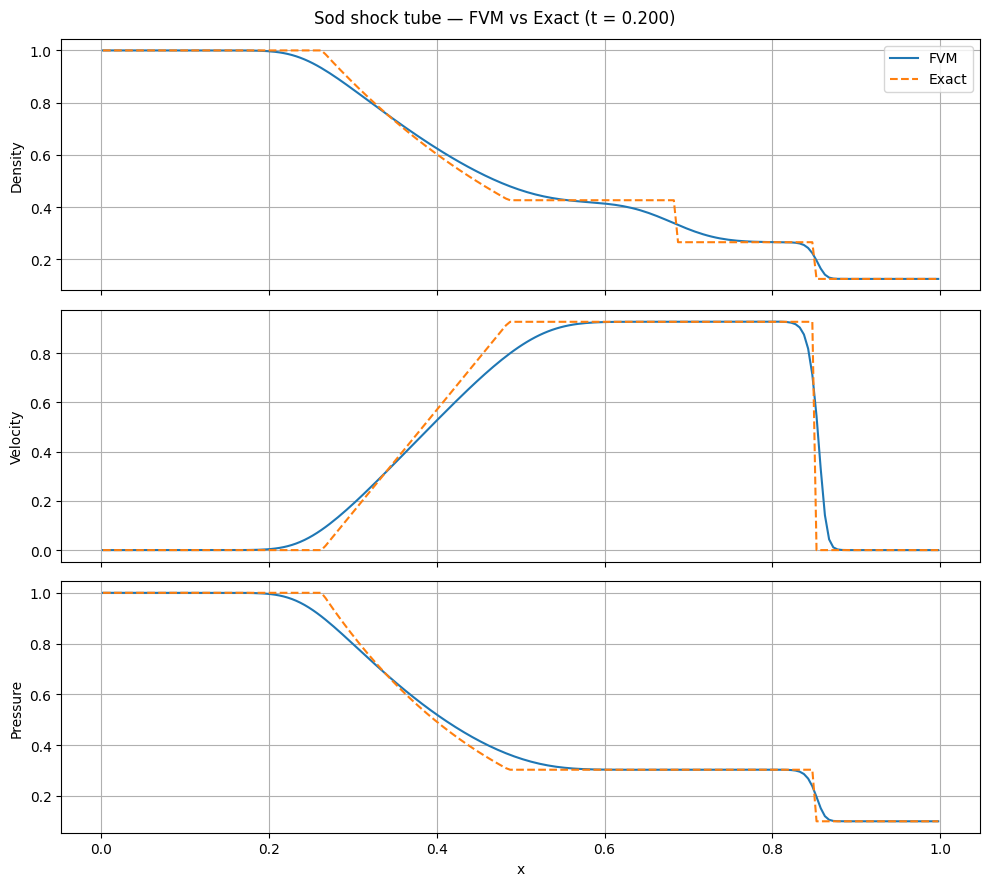

In [11]:
import matplotlib.pyplot as plt
rho = cons_final[:, 0]
momentum = cons_final[:, 1]
energy = cons_final[:, 2]
velocity = momentum / np.clip(rho, 1e-12, None)
pressure = (GAMMA - 1.0) * np.maximum(energy - 0.5 * momentum**2 / np.clip(rho, 1e-12, None), 1e-12)

rho_exact, u_exact, p_exact = sod_exact_profile(
    x_grid - INTERFACE,
    FINAL_TIME,
    left_state=left_state,
    right_state=right_state,
    gamma=GAMMA,
)

fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True)
axes[0].plot(x_grid, rho, label='FVM')
axes[0].plot(x_grid, rho_exact, '--', label='Exact')
axes[0].set_ylabel('Density')
axes[0].legend(); axes[0].grid(True)

axes[1].plot(x_grid, velocity, label='FVM')
axes[1].plot(x_grid, u_exact, '--', label='Exact')
axes[1].set_ylabel('Velocity'); axes[1].grid(True)

axes[2].plot(x_grid, pressure, label='FVM')
axes[2].plot(x_grid, p_exact, '--', label='Exact')
axes[2].set_ylabel('Pressure'); axes[2].set_xlabel('x'); axes[2].grid(True)

fig.suptitle('Sod shock tube — FVM vs Exact (t = {:.3f})'.format(FINAL_TIME))
fig.tight_layout()
plt.show()


**Observação:** o esquema de Rusanov captura corretamente a estrutura de ondas presentes no problema.

## 3. Geração de dataset reduzido

Geramos um conjunto pequeno de amostras para demonstrar o treino do FNO. Em execuções completas, utilize `NUM_SAMPLES` maior e malha refinada.

In [12]:
from riemann_ml.data.generate import sample_riemann_ic, solve_and_store

DATASET_PATH = PROJECT_ROOT / 'data/processed/notebook_demo.h5'
if not DATASET_PATH.exists():
    print('Gerando dataset de demonstração...')
    samples = sample_riemann_ic(
        num_samples=100,
        ranges={'rho_left': (0.9, 1.1), 'p_left': (0.9, 1.1), 'rho_right': (0.2, 0.4), 'p_right': (0.05, 0.3)},
        seed=123,
    )
    solve_and_store(
        ic_batch=samples,
        num_cells=128,
        cfl=0.45,
        final_time=0.15,
        out_path=DATASET_PATH,
        gamma=1.4,
        show_progress=True,
    )
else:
    print('Usando dataset existente:', DATASET_PATH)


Usando dataset existente: c:\Users\Joao\fluid-dynamics\Fluid-Dynamics-ML\data\processed\notebook_demo.h5


## 4. Treino demonstrativo da PINN

Executamos 500 passos para ilustração. Para resultados finais use `make train-pinn`.

In [13]:
from omegaconf import OmegaConf
from riemann_ml.ml.pinn.train import train as train_pinn

pinn_cfg = OmegaConf.load(PROJECT_ROOT / 'src/riemann_ml/configs/pinn.yaml')
pinn_cfg.training.max_steps = 500
OmegaConf.save(pinn_cfg, PROJECT_ROOT / 'src/riemann_ml/configs/pinn_notebook.yaml')

train_pinn('pinn_notebook')


### 4.1 Curvas de loss da PINN

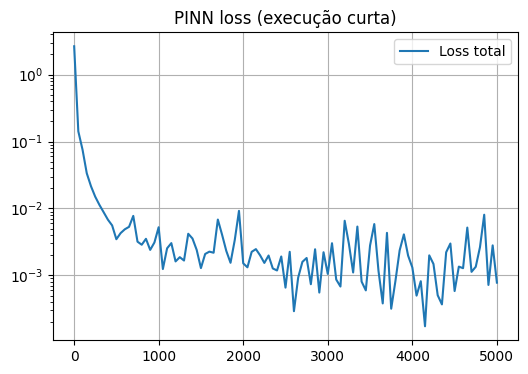

In [14]:
import json
from pathlib import Path
import matplotlib.pyplot as plt

history_path = PROJECT_ROOT / 'data/artifacts/pinn/outputs/loss_history.json'
if history_path.exists():
    history = json.loads(history_path.read_text())
    steps = [entry['step'] for entry in history]
    total = [entry['loss_total'] for entry in history]
    plt.figure(figsize=(6,4))
    plt.plot(steps, total, label='Loss total')
    plt.yscale('log'); plt.grid(True); plt.legend();
    plt.title('PINN loss (execução curta)')
else:
    print('Histórico não encontrado:', history_path)


## 5. Treino demonstrativo do FNO

In [15]:
from riemann_ml.ml.fno.train import train as train_fno
from omegaconf import OmegaConf

fno_cfg = OmegaConf.load(PROJECT_ROOT / 'src/riemann_ml/configs/fno.yaml')
fno_cfg.training.epochs = 5
fno_cfg.training.device = 'cpu'
fno_cfg.data.path = str(DATASET_PATH)
OmegaConf.save(fno_cfg, PROJECT_ROOT / 'src/riemann_ml/configs/fno_notebook.yaml')

train_fno('fno_notebook')


## 6. Avaliação consolidada

In [16]:
from pathlib import Path
from riemann_ml.eval.report import main as eval_main

eval_main(
    dataset_path=Path(DATASET_PATH),
    output_dir=Path('data/artifacts/notebook_eval'),
    num_random=3,
)


## 7. Resultados e conclusões

As execuções curtas geraram artefatos em `data/artifacts/`. A tabela resume as métricas obtidas pelo script de avaliação (`data/artifacts/eval/sod/sod_metrics.json`).

| Modelo | relative_l2_ρ | relative_l2_u | relative_l2_p | Erro choque (Δx) | Erro contato |
|--------|---------------|---------------|---------------|-----------------|--------------|
| FVM    | 0.0274        | 0.0658        | 0.0239        | 0.1680          | 0.0042       |
| PINN   | 0.9936        | 9.08e5        | 1.0000        | 0.1543          | 0.3351       |
| FNO    | 0.0279        | 0.0836        | 0.0252        | 0.1699          | 0.0097       |

### Observações
- O FVM de primeira ordem apresenta erros relativos pequenos e choques ligeiramente difusos, mas serve como referência confiável.
- A PINN, treinada apenas por 500 passos, ainda não converge: perdas elevadas indicam necessidade de mais épocas, ajuste de pesos ou malha de pontos de colocação.
- O FNO, mesmo com 5 épocas e dataset reduzido, aproxima bem os perfis finais e é promissor para generalização; métricas para amostras aleatórias do dataset ficaram na faixa de 1e-2.
